<a href="https://colab.research.google.com/github/NAyeshaKhan/EDD_audio/blob/main/TL_NasNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [ ]:
BATCH = 32
SIZE = 224
SEED = 42

EPOCHS = 10
LR = 1e-6
FILTERS = 6
KERNEL = 3
STRIDES = 1
REGRATE = 0.0
POOL = 2
DORATE = 0.05
NLABELS = 3
DENSE1 = 128
DENSE2 = 64
# Define paths to your data
train_dir ="/content/drive/MyDrive/STFT_robo/train"
validation_dir ="/content/drive/MyDrive/STFT/val"

BATCH_SIZE = 16
IMG_SIZE = (224,224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True,
                                                            batch_size=BATCH_SIZE, image_size=IMG_SIZE,
                                                            label_mode='categorical'  # Ensure labels are one-hot encoded
                                                            )
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,shuffle=True,
                                                            batch_size=BATCH_SIZE, image_size=IMG_SIZE, label_mode='categorical'
                                                            )
class_names = train_dataset.class_names
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.2)
],
    name="img_augmentation",)


backbone = tf.keras.applications.NASNetMobile(
    input_shape=(SIZE, SIZE, 3),
    include_top=False,
    weights="imagenet"
)

backbone.trainable = False
# Unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in backbone.layers[-40:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

input = tf.keras.Input(shape=(SIZE,SIZE,3))
x = data_augmentation(input)
x = backbone(x, training=False)
# Rebuild non-frozen top layers of NASNetMobile, which was initialized with include_top=False
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dense(DENSE1, activation="relu")(x)
x = Dropout(DORATE)(x)  # Add dropout after dense layer
x = Dense(DENSE2, activation="relu")(x)
x = Dropout(DORATE)(x)  # Add dropout after dense layer
output = Dense(3, activation="softmax", name="pred")(x)

nasnet_model = Model(input, output, name="NASNetMobile")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Save the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

loss_function = tf.keras.losses.CategoricalCrossentropy()

metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

nasnet_model.compile(
    optimizer = Adam(learning_rate=LR, clipnorm=1.0),
    loss = loss_function,
    metrics = metrics
)

tf.config.run_functions_eagerly(True)
# Using a learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LR * 0.9 ** epoch
)

nasnet_history = nasnet_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = EPOCHS,
    verbose = 1,
    # callbacks=[checkpoint_callback, early_stopping_callback]
)

nasnet_model.evaluate(validation_dataset)
# loss: 3.2046 - accuracy: 0.1838


Found 756 files belonging to 3 classes.
Found 236 files belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 379s 8s/step - accuracy: 0.3716 - loss: 1.1660 - val_accuracy: 0.3347 - val_loss: 1.1196
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 379s 8s/step - accuracy: 0.3118 - loss: 1.1977 - val_accuracy: 0.3390 - val_loss: 1.1068
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 393s 8s/step - accuracy: 0.3348 - loss: 1.1769 - val_accuracy: 0.3432 - val_loss: 1.1045
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 439s 8s/step - accuracy: 0.3722 - loss: 1.1825 - val_accuracy: 0.3432 - val_loss: 1.1041
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 447s 8s/step - accuracy: 0.3160 - loss: 1.2141 - val_accuracy: 0.3475 - val_loss: 1.1061
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 435s 8s/step - accuracy: 0.3182 - loss: 1.2290 - val_accuracy: 0.3390 - val_loss: 1.1091
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 387s 8s/step - accuracy: 0.3370 - loss: 1.2286 - val_accuracy: 0.3475 - val_loss: 1.1120
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 435s 8s/step - accuracy: 0.3252 - loss: 1.1852 - val_accuracy: 0.3475 - v

[1.1179307699203491, 0.35169491171836853]

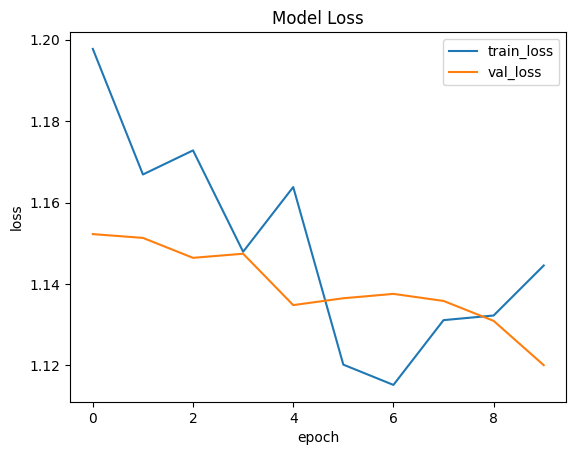

In [ ]:
import matplotlib.pyplot as plt
plt.plot(nasnet_history.history['loss'])
plt.plot(nasnet_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.savefig('NASNetMobile_FT_01.webp', bbox_inches='tight')

In [ ]:
# Define paths to your data
train_dir ="/content/drive/MyDrive/STFT/train"
validation_dir ="/content/drive/MyDrive/STFT/val"
#TRY CWTS TOO??
# Image data generator with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize image pixels to [0, 1]
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Size for NasNetMobile
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Found 249 images belonging to 3 classes.
Found 236 images belonging to 3 classes.
Using device: cpu


In [ ]:
# Load pre-trained NasNetMobile model without the top classification layer
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='softmax')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(3, activation='softmax')(x)  # Use 'sigmoid' for binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 181s 21s/step - accuracy: 0.3683 - loss: 1.0975 - val_accuracy: 0.3347 - val_loss: 1.0986
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 192s 21s/step - accuracy: 0.3809 - loss: 1.0967 - val_accuracy: 0.3347 - val_loss: 1.0986
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 202s 21s/step - accuracy: 0.3629 - loss: 1.0965 - val_accuracy: 0.3347 - val_loss: 1.0986
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 205s 21s/step - accuracy: 0.3887 - loss: 1.0945 - val_accuracy: 0.3347 - val_loss: 1.0986
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 212s 23s/step - accuracy: 0.4395 - loss: 1.0901 - val_accuracy: 0.3220 - val_loss: 1.0986
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 192s 22s/step - accuracy: 0.4312 - loss: 1.0891 - val_accuracy: 0.3093 - val_loss: 1.0986
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 200s 21s/step - accuracy: 0.3628 - loss: 1.0944 - val_accuracy: 0.3136 - val_loss: 1.0986
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 177s 22s/step - accuracy: 0.3897 - loss: 1.0829 - val_accuracy: 0.3347 - val_loss: 1.0986
Epo